In [28]:
import os
import torch
import d2l.torch as d2l


In [20]:
with open('fra.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

print(raw_text[:75])

Hello, how are you today?	Bonjour, comment allez-vous aujourd'hui ?
The wea


In [21]:
def preprocess_numt(text):
    def no_space(char,prev_char):
        return char in set(',.!?') and prev_char != ' '

    #替换识别不了的字符，替换不正常的空格，变小写
    text = text.replace('\u202f',' ').replace('\xa0',' ').lower()
    out = [' ' + char if i > 0 and no_space(char,text[i - 1]) else char for i,char in enumerate(text)] 
    return ''.join(out)

In [22]:
text = preprocess_numt(raw_text)
print(text[:75])

hello , how are you today ?	bonjour , comment allez-vous aujourd'hui ?
the 


In [23]:
#词元化
def tokenize_nmt(text,num_examples=None):
    source,target = [],[]
    for i,line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t') #制表符
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source,target

In [29]:
source,target = tokenize_nmt(text)

In [45]:
len(source)

91

In [39]:
#统计每句话的长度的分布情况
def show_list_len_pair_hist(legend,xlabel,ylabel,xlist,ylist):
    d2l.set_figsize()
    _,_,patches = d2l.plt.hist([[len(l) for l in xlist],[len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
        d2l.plt.legend(legend)



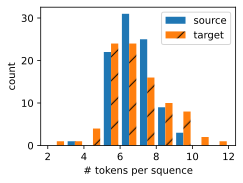

In [40]:
show_list_len_pair_hist(['source','target'],'# tokens per squence','count',source,target)

In [41]:
src_vocab = d2l.Vocab(source,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
len(src_vocab)

59

In [49]:
def truncate_pad(line,num_steps,padding_token):
    #阶段或者填充文本序列
    if len(line) > num_steps:
        return line[:num_steps] #太长，截断
    return line + [padding_token] * (num_steps - len(line)) #填充
    

In [50]:
truncate_pad(src_vocab[source[0]],10,src_vocab['<pad>'])

[6, 1, 24, 11, 57, 6, 7, 5, 5, 5]

In [59]:
#将机器翻译的文本序列转换成小批量tensor
def build_array_nmi(lines,vocab,num_steps):
    #通过vocab拿到line的索引
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['eos']] for l in lines]
    array = torch.tensor([truncate_pad(l,num_steps,vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int).sum(1)
    return array,valid_len

In [60]:
#加载数据
def load_data_nmt(batch_size,num_steps,num_examples=600):
    #需要返回数据集的迭代器和词表
    text = preprocess_numt(raw_text)
    source,target = tokenize_nmt(text,num_examples)
    src_vocab = d2l.Vocab(source,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = d2l.Vocab(target,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
    src_array,src_valid_len = build_array_nmi(source,src_vocab,num_steps)
    tgt_array,tgt_valid_len = build_array_nmi(target,tgt_vocab,num_steps)
    data_arrays = (src_array,src_valid_len,tgt_array,tgt_valid_len)
    data_iter = d2l.load_array(data_arrays,batch_size)
    return data_iter,src_vocab,tgt_vocab

In [63]:
#使用一下
train_iter,src_vocab,tgt_vocab = load_data_nmt(batch_size=2,num_steps=8)

In [64]:
for x,x_valid_len,y,y_valid_len in train_iter:
    print('x:',x.type(torch.int32))
    print('x的有效长度:',x_valid_len)
    print('y:',y.type(torch.int32))
    print('y的有效长度:',y_valid_len)
    break

x: tensor([[31,  6, 12, 47,  6,  6,  2,  6],
        [47,  6, 29, 51,  6,  2,  6,  5]], dtype=torch.int32)
x的有效长度: tensor([8, 7])
y: tensor([[ 6, 55,  6,  6,  2,  6,  5,  5],
        [24, 23, 49,  6,  2,  6,  5,  5]], dtype=torch.int32)
y的有效长度: tensor([6, 6])
